# Data Analysis and Classic Machine Learning Techniques
***
# Table of Contents
1.   [Imports](#Imports)
2.   [Loading The Dataset](#Loading-The-Dataset)
3.   [Data Analysis](#Data-Analysis)
4.   [Data Pre-Processing](#Data-Pre-Processing)
4.   [Different Model Comparison](#Different-Model-Comparison)
5.   [Support Vector Machine](#Support-Vector-Machine)


# Imports

The necessary libraries are imported at this stage.

* pandas - Dataframe object is useful for data processing and analyses.
* sklearn - Provides a number of models, metrics and general functionality for machine learning.
* matplotlib - Provides plotting.

In [1]:
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import itertools
import numpy as np
#from google.colab import drive #Only needed on Colab
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
# Pretty display for notebooks
%matplotlib inline

# Loading The Dataset

In this section we load the dataset first from a single file.

Using **sklearn** functions, this dataset is split into the training and testing data, which are then exported as CSV files.

In [2]:
def split_data():
    """Splits dataset into training and testing and exports them as CSV files"""

    all_data = pd.read_csv("Our Datasets/all data.csv", encoding="utf-8")

    train_pct_index = int(0.8 * len(all_data))
    all_data = shuffle(all_data)
    
    train, test = all_data[:train_pct_index], all_data[train_pct_index:]
    
    train.to_csv('train.csv', index = False)
    test.to_csv('test.csv', index = False)
split_data()

In [3]:
#mount drive
#drive.mount("/content/drive")
#path_to_data = "" #"drive/MyDrive/Kaggle/"


train = pd.read_csv("Our Datasets/train.csv", encoding="utf-8")
test = pd.read_csv("Our Datasets/test.csv", encoding="utf-8")

#Check it loaded ok
#display(train.head(n=1))
#display(test.head(n=1))

In [4]:
print("\nTrain:\n")
print(train.head())
print(train.shape)

print("\nTest:\n")
print(test.head())
print(test.shape)


Train:

       Label  angle(X-axis, gravityMean  angle(Y-axis, gravityMean  \
0    WALKING                   1.225186                   2.780770   
1    SITTING                   2.660907                   1.449907   
2    DRIVING                   2.119445                   1.571007   
3    WALKING                   1.494537                   3.061788   
4  STAIRS UP                   1.794659                   2.883742   

   angle(Z-axis, gravityMean  angle(tBodyAccJerkMean, gravityMean)  \
0                   1.471262                              1.691630   
1                   1.108075                              0.701558   
2                   0.548649                              1.481140   
3                   1.594271                              2.005371   
4                   1.444991                              0.082229   

   angle(tBodyAccMean, gravityMean)  angle(tBodyGyroJerkMean, gravityMean)  \
0                          2.334304                               2.829

# Data Analysis

In this section analysis over the data is done to determine the processing steps necessary for the [next section](#Data-Pre-Processing).

## Check for Common Elements

The training and test data are merged using inner join to see if there is any overlapping data. The output is an empty data frame - containing only the list of different features - meaning that there are no intersections between the two.

In [5]:
merged = pd.merge(train, test, how='inner')
print(merged)

        Label  angle(X-axis, gravityMean  angle(Y-axis, gravityMean  \
0   STAIRS UP                   1.602190                   2.995247   
1   STAIRS UP                   1.602690                   2.992963   
2   STAIRS UP                   1.525130                   3.085529   
3   STAIRS UP                   1.502710                   3.056343   
4   STAIRS UP                   1.563974                   3.127073   
5   STAIRS UP                   1.490556                   3.061348   
6   STAIRS UP                   1.486719                   3.044342   
7   STAIRS UP                   1.579599                   3.070896   
8   STAIRS UP                   1.560009                   3.042105   
9   STAIRS UP                   1.481479                   3.002574   
10  STAIRS UP                   1.557301                   3.012828   
11  STAIRS UP                   1.526217                   3.092833   
12  STAIRS UP                   1.576891                   2.991640   
13  ST

## Shuffle the data

In [6]:
train = shuffle(train)
test = shuffle(test)

## Check for null values in rows

In [7]:
print("Any missing sample in training set:", train.isnull().values.any())
print("Any missing sample in test set:", test.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in test set: False 



## Label Distribution

### Label Distribution in a Pie Chart

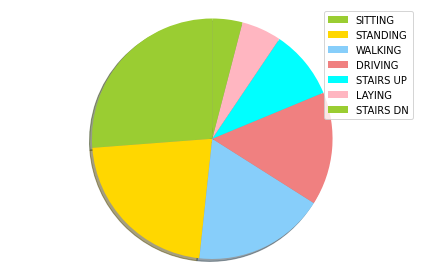

In [8]:
# Visualizing Training Activity Distribution
temp = train["Label"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

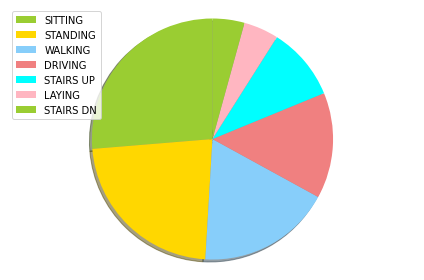

In [44]:
# Visualizing Test Activity Distribution
temp = test["Label"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

### Label Distribution in a Column Format

In [9]:
train_outcome = pd.crosstab(index=train["Label"], columns="count")
test_outcome = pd.crosstab(index=test["Label"], columns="count")
print("Training Data")
print(train_outcome)
print("\nTest Data")
print(test_outcome)

Training Data
col_0      count
Label           
DRIVING      584
LAYING       206
SITTING     1004
STAIRS DN    155
STAIRS UP    357
STANDING     846
WALKING      679

Test Data
col_0      count
Label           
DRIVING      148
LAYING        49
SITTING      246
STAIRS DN     49
STAIRS UP    115
STANDING     201
WALKING      150


# Data Pre-Processing

The dataset only requires a small number of pre-processing mainly, splitting the sets into X and y variables, categorical
variable encoding (for the label), and scaling.

The *activity* and *subject* columns are removed from the training and test data. **Y_train_label** and **Y_test_label** are the classifications of the activity of each row in the respective dataframes.

In [10]:
X_train = pd.DataFrame(train.drop(['Label'],axis=1))
Y_train_label = train.Label.values.astype(object)
X_test = pd.DataFrame(test.drop(['Label'],axis=1))
Y_test_label = test.Label.values.astype(object)

print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
encoder = preprocessing.LabelEncoder()

# encoding train labels
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continuous features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of Continuous Features:",num_cols.size)

#names_of_predictors = list(X_train.columns.values) #Names of each feature

# Scaling the Train and Test feature set
# Because - values and classification
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #fit_transform is performed on training data
X_test_scaled = scaler.transform(X_test) #transform is performed on test data

Dimension of Train set (3831, 359)
Dimension of Test set (958, 359) 

Number of Continuous Features: 359


# Different Model Comparison

In this step we compare 4 classic ml models.

In [11]:
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state=0)
clf_C = SVC(random_state=0)
clf_D = NuSVC(random_state=0)

learners = {}
learners["Gaussian Naive Bayes"] = clf_A
learners["AdaBoost"] = clf_B
learners["Support Vector Machine"] = clf_C
learners["Nu-Support Support Vector Machine"] = clf_C

def train_predict(learners, X_train, y_train, X_test, y_test):
    for learner in learners:
        print("Learner:", learner,"\n------")
        print("Training Data")
        start = time()
        learners[learner].fit(X_train, y_train)
        end = time()
        print("Time taken:", end-start, "seconds")

        print("Testing Data")
        start = time()
        predictions_test = learners[learner].predict(X_test)
        end = time()
        print("Time taken:", end-start, "seconds")


        print("\nAccuracy Score")
        print(accuracy_score(y_test,predictions_test))

        print("\nBeta Score")
        print(fbeta_score(y_test,predictions_test,beta=0.5,average='weighted'))

        print("\nPrecision Score")
        print(precision_score(y_test, predictions_test, average='weighted'))

        print("\nRecall Score")
        print(recall_score(y_test, predictions_test, average='weighted'),'\n')

train_predict(learners, X_train_scaled, Y_train, X_test_scaled, Y_test)

Learner: Gaussian Naive Bayes 
------
Training Data
Time taken: 0.029999494552612305 seconds
Testing Data
Time taken: 0.015996217727661133 seconds

Accuracy Score
0.7233820459290188

Beta Score
0.781660458831619

Precision Score
0.8206573648050105

Recall Score
0.7233820459290188 

Learner: AdaBoost 
------
Training Data
Time taken: 6.526113986968994 seconds
Testing Data
Time taken: 0.04199862480163574 seconds

Accuracy Score
0.5918580375782881

Beta Score
0.4646792620997143

Precision Score
0.4505010579589416

Recall Score
0.5918580375782881 

Learner: Support Vector Machine 
------
Training Data
C:\Users\Jake Sant\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Time taken: 0.3229994773864746 seconds
Testing Data
Time tak

As can be seen from the above metrics, SVM is quite clearly the most accurate classifier of the three, and it is for that reason that we will use it as one of the main classifiers for the group practical task

# Support Vector Classifier

There are a number of different parameters we can apply to SVC in order to obtain the best results possible. These different parameters were passed through a Grid Search model, which applies all of them to train various SVCs.

In [12]:
clf = SVC(random_state=0)

parameters =    {
                "kernel": ['poly', 'rbf', 'sigmoid'],
                "C": [50, 10, 1.0, 0.1, 0.01],
                "gamma": ['scale']
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train_scaled,Y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train_scaled, Y_train)
# Make predictions using the unoptimized and model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test_scaled)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(Y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(Y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(Y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(Y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(Y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(Y_test, best_predictions, average='weighted')))

Unoptimized model
------
Accuracy score on the testing data: 0.1566
F-score on the testing data: 0.0295
Precision score on the testing data: 0.0245
Recall score on the testing data: 0.1566

Optimized Model
------
Final accuracy score on the testing data: 0.9760
Final F-score on the testing data: 0.9765
Final precision score on the testing data: 0.9768
Final recall score on the testing data: 0.9760
C:\Users\Jake Sant\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


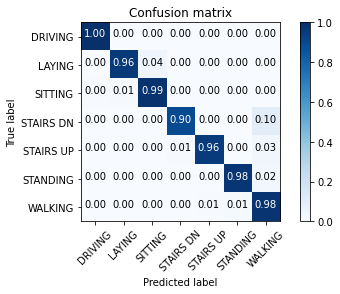

In [14]:
#Confusion Matrix maps out the predicted label given to the data with the actual label
#Helps us check the rate of true/false positives and true/false negatives
#parameters are the true labels, and the predicted labels

# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Y_test, best_predictions)
np.set_printoptions(precision=2)

classes =    {
                        "DRIVING":0,
                        "LAYING":1,
                        "SITTING":2,
                        "STAIRS DN":3,
                        "STAIRS UP":4,
                        "STANDING":5,
                        "WALKING":6
                    }

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='Confusion matrix')


In [15]:
print("The best parameters were:", grid_fit.best_params_)


The best parameters were: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
